In [12]:
import json
from utils import *
from pyltp import Segmentor



In [2]:
MAX_SENT_LENGTH = 200#最大句长
MAX_TOKEN_LENGTH = 10#最大单词长度 不超过20个字符


In [3]:
def searchword(sentlist,charindex):
    cid=0
    for (wid,word) in enumerate(sentlist):
        if cid==charindex:
            return wid
        cid+=len(word)
    return -1
        

In [4]:
def search(pat, txt):#找到pat(单词)在txt子串的第一次出现位置
    i, N = 0, len(txt)
    j, M = 0, len(pat)
    while i < N and j < M:
        if txt[i] == pat[j]:
            j = j + 1
        else:
            i -= j
            j = 0
        i = i + 1
    if j == M:
        return i - M
    else:
        return -1



In [5]:
def make_tag_set(tag_set, relation_label):##生成标签集合tag_set
    if relation_label == "None":
        return
    for pos in "BIES":
        for role in "12":
            tag_set.add("-".join([pos, relation_label, role]))#pos-relation_label-role


In [6]:
def update_tag_seq(em_text, e_start, sentence_text, relation_label, role, tag_set, tags_idx):#给句子中的实体打标签 得到tags_idx
    overlap = False
    wrongstart=0
    #start = search(em_text, sentence_text)#得到句子中的实体第一个词的位置
    start=searchword(sentence_text,e_start)
    if start==-1:
        wrongstart+=1
    tag = "-".join(["S", relation_label, str(role)])
    if len(em_text) == 1:
        #print(em_text,e_start)
        if tags_idx[start] != tag_set["O"]:
            overlap = True
        tags_idx[start] = tag_set[tag]#S-...-...
    else:
        tag = "B" + tag[1:]
        if tags_idx[start] != tag_set["O"]:
            overlap = True
        tags_idx[start] = tag_set[tag]
        tag = "E" + tag[1:]
        end = start + len(em_text) - 1 #计算实体词的长度
        if tags_idx[end] != tag_set["O"]:
            overlap = True
        tags_idx[end] = tag_set[tag]
        tag = "I" + tag[1:]
        for index in range(start + 1, end):
            if tags_idx[index] != tag_set["O"]:
                overlap = True
            tags_idx[index] = tag_set[tag]
            
    #print("wrong start:",wrongstart)
    return overlap              #返回重复的已标记过的实体



In [1]:
# def prepare_sequence(seq, to_idx):
#     return [to_idx[key] for key in seq]

In [8]:
#prepare_data_set(fin, charset, vocab, relation_labels, entity_labels, tag_set, train, fout)
#参数：输入的.json文件，字符集对象，单词集合对象（已导入词典），关系标签，实体标签，实体-关系标签集合，train/test list，overlap.txt文件
def prepare_data_set(fin, charset, vocab, relation_labels, entity_labels, tag_set, dataset, fout,data_seg):##预处理数据集  json->.pk
#     seg= Segmentor()  # 生成对象
#     seg.load('../../data/cws.model')
    num_overlap = 0
    for line in fin:
        overlap = False
        line = line.strip()
        if not line:
            continue  #结束则跳出循环
        sentence = json.loads(line)#将json数据转换成python对象  这里是转换为了字典
        #print(sentence)
        for relation_mention in sentence["relationMentions"]:
            relation_labels.add(relation_mention["label"])  #记录关系类型
            make_tag_set(tag_set, relation_mention["label"]) #生成标签集合 BIES-relation-12
        for entity_mention in sentence["entityMentions"]:
            entity_labels.add(entity_mention["label"])  #记录实体类型
        #sentence_text = sentence["sentText"].strip().strip('"').split()#保存文本为单词list
        sentence_text=list(seg.segment(sentence["sentText"].strip().strip('"')))
        
        length_sent = len(sentence_text) #该条文本长度
        #print(length_sent)
        if length_sent > MAX_SENT_LENGTH:#设置了最大句长
            continue

        #lower_sentence_text = [token.lower() for token in sentence_text] #全部变成小写
        #sentence_idx = prepare_sequence(lower_sentence_text, vocab) #vocab是词和id的映射 将sentence中的每个词转为对应的id值得到id的list
        sentence_idx = prepare_sequence(sentence_text, vocab) #vocab是词和id的映射 将sentence中的每个词转为对应的id值得到id的list
        
    
        tokens_idx = []
        for token in sentence_text:
            if len(token) <= MAX_TOKEN_LENGTH:  #### 每一个字在字典中对应的id
                tokens_idx.append(prepare_sequence(token, charset) + [charset["<pad>"]]*(MAX_TOKEN_LENGTH-len(token)))  #<pad>是补齐单词所用的字符
            else:
                tokens_idx.append(prepare_sequence(token[0:7] + token[-3:], charset))#单词长度大于20 则选择前13个和后7个

        tags_idx = [tag_set["O"]] * length_sent #length_sent是该句子的长度  初始化为全0
        for relation_mention in sentence["relationMentions"]:
            if relation_mention["label"] == "None":
                continue
            em1_text = relation_mention["em1Text"].split()  #英文中 对phrase分词
            e1_s=int(relation_mention["e1start"])
            res1 = update_tag_seq(em1_text, e1_s, sentence_text, relation_mention["label"], 1, tag_set, tags_idx)#对句子中的实体打标签
            em2_text = relation_mention["em2Text"].split()
            e2_s=int(relation_mention["e21start"])
            res2 = update_tag_seq(em2_text, e2_s, sentence_text, relation_mention["label"], 2, tag_set, tags_idx)
            if res1 or res2:
                num_overlap += 1 #重复
                overlap = True
        dataset.append((sentence_idx, tokens_idx, tags_idx))            #dateset是train/test  包含三部分 句子中每个词的id 句子中每个词对应的char的id 句子对应的实体id
        data_seg.append(' '.join(sentence_text))
        if overlap:
            fout.write(line+"\n")
    return num_overlap  #返回重复的已标记过的语句
    


In [11]:
if __name__ == "__main__":
    
    Chinesecorpus=open('../../data/mycorpus.txt','rt',encoding='utf-8').read()
    corpus_char=''.join(set(list(Chinesecorpus)))
    charset=ChineseCharset(corpus_char)

    vocab = Vocabulary()
    vocab.load("../../data/myvocab_more.txt")
    relation_labels = Index()
    entity_labels = Index()
    tag_set = Index()
    tag_set.add("O")

    with open("my_overlap.txt", "wt", encoding="utf-8") as fout:
        train = []
        train_seg=[]
        with open(r'mytrain_seg.txt','wt',encoding='utf-8') as fseg:
            with open('../../data/mytrain.json', 'rt', encoding='utf-8') as fin:##对训练集进行预处理
                res = prepare_data_set(fin, charset, vocab, relation_labels, entity_labels, tag_set, train, fout,train_seg)##参数：输入的.json文件，字符集对象，单词集合对象，关系标签，实体标签，实体-关系标签集合，train/test list，overlap.txt文件
                #print("# of overlaps in train data: {}".format(res))
            save(train, 'my_train.pk')
            #print(len(train_seg))
            fseg.write('\n'.join(train_seg))
        print('begin...')
        test=[]
        test_seg=[]
        with open('mytest_seg.txt','wt',encoding='utf-8') as fseg:
            with open(r'..\..\data/mytest.json', 'rt', encoding='utf-8') as fin:##对训练集进行预处理
                res = prepare_data_set(fin, charset, vocab, relation_labels, entity_labels, tag_set, test, fout,test_seg)##参数：输入的.json文件，字符集对象，单词集合对象，关系标签，实体标签，实体-关系标签集合，train/test list，overlap.txt文件
                #print("# of overlaps in train data: {}".format(res))
            save(test, 'my_test.pk')
            fseg.write('\n'.join(test_seg))
            #print(test_seg)
            #print(len(test_seg))
        print('over...')
    relation_labels.save('my_relation_labels.txt')
    entity_labels.save('my_entity_labels.txt')
    tag_set.save("my_tag2id.txt")

# of overlaps in train data: 42924
# of overlaps in test data: 18


begin...
over...


In [39]:
seg= Segmentor()  # 生成对象
seg.load('data/cws.model')

In [68]:

with open('data\mytest_seg.txt','wt',encoding='utf-8') as fout:
    with open('data\mytest.json', 'r', encoding='utf-8') as fin:##对训练集进行预处理
        testDicts=[]
        for line in fin:
            
            testDicts.append(json.loads(line))#将json数据转换成python对象  这里是转换为了字典
        print(count)
    count=0
    sents=[]
    for td in testDicts:
        count+=1
        sents.append(' '.join(list(seg.segment(td['sentText'].strip().strip('"')))))
    #print(type(test_seg[1]),type(sents[1]),len(test_seg),len(sents))
    #fout.write('\n'.join(sents))
    

550
<class 'list'> <class 'str'> 531 550


In [73]:
q=[([2,3,5],2,3),([4,2,1,5,6],3,4),([1],6,7),([3,2],6,9)]

In [74]:
sorted_q= sorted(q, key=lambda x: len(x[0]), reverse=True)

In [75]:
sorted_q

[([4, 2, 1, 5, 6], 3, 4), ([2, 3, 5], 2, 3), ([3, 2], 6, 9), ([1], 6, 7)]

In [56]:
corpus=open('data/mycorpus.txt','rt',encoding='utf-8').read()
corpus_char=''.join(set(list(corpus)))
charset=chineseCharset(corpus_char)

vocab = Vocabulary()
vocab.load("data/NYT_CoType/vocab.txt")
relation_labels = Index()
entity_labels = Index()
tag_set = Index()
tag_set.add("O")
with open("my_overlap.txt", "wt", encoding="utf-8") as fout:
    train = []
    with open('data/mytrain.json', 'rt', encoding='utf-8') as fin:##对训练集进行预处理
        ll = prepare_data_set(fin, charset, vocab, relation_labels, entity_labels, tag_set, train, fout)

        
result={}
for i in set(ll):
    result[i]=ll.count(i)


永嘉县 3
人民 2
检察院 3
指控 2
， 1
2014年 5
2月 2
4日 2
、 1
2月 2
7日 2
， 1
经 1
房婉路 3
（ 1
已 1
判决 2
） 1
居中 2
撮合 2
， 1
被告人 3
宋爱华 3
先后 2
两 1
次 1
在 1
温州市 3
鹿城区 3
新田园 3
旁 1
建筑 2
工地 2
附近 2
， 1
将 1
共计 2
约 1
15 2
克 1
的 1
甲基苯丙胺 5
（ 1
冰毒 2
） 1
贩卖 2
给 1
詹某 2
（ 1
已 1
判决 2
） 1
。 1
永嘉县 3
人民 2
检察院 3
指控 2
， 1
2014年 5
2月 2
4日 2
、 1
2月 2
7日 2
， 1
经 1
房婉路 3
（ 1
已 1
判决 2
） 1
居中 2
撮合 2
， 1
被告人 3
宋爱华 3
先后 2
两 1
次 1
在 1
温州市 3
鹿城区 3
新田园 3
旁 1
建筑 2
工地 2
附近 2
， 1
将 1
共计 2
约 1
15 2
克 1
的 1
甲基苯丙胺 5
（ 1
冰毒 2
） 1
贩卖 2
给 1
詹某 2
（ 1
已 1
判决 2
） 1
。 1
永嘉县 3
人民 2
检察院 3
指控 2
， 1
2014年 5
2月 2
4日 2
、 1
2月 2
7日 2
， 1
经 1
房婉路 3
（ 1
已 1
判决 2
） 1
居中 2
撮合 2
， 1
被告人 3
宋爱华 3
先后 2
两 1
次 1
在 1
温州市 3
鹿城区 3
新田园 3
旁 1
建筑 2
工地 2
附近 2
， 1
将 1
共计 2
约 1
15 2
克 1
的 1
甲基苯丙胺 5
（ 1
冰毒 2
） 1
贩卖 2
给 1
詹某 2
（ 1
已 1
判决 2
） 1
。 1
经 1
审理 2
查明 2
， 1
1 1
、 1
2013年 5
8月 2
初 1
的 1
一 1
天 1
20时 3
许 1
， 1
被告人 3
崔 1
某某 2
在 1
沈阳市 3
大东区 3
大什字街 4
103 3
号 1
大悦城 3
C 1
座 1
1111 4
房间 2
内 1
， 1
以 1
人民币 3
3500 4
元 1
的 1
价格 2
贩卖 2
给 1
李 1
某某 2
冰毒 2
3 1
小 1
袋 1
， 1
每 1
袋 1
约 1
重 1

城区 2
吴家沟 3
村口 2
等 1
地 1
， 1
以 1
每 1
克 1
2000 4
元 1
的 1
价格 2
多次 2
卖 1
给 1
吸毒 2
人员 2
孟 1
某某 2
1 1
毒品 2
海洛因 3
共计 2
5 1
克 1
， 1
获取 2
毒资 2
10000 5
元 1
。 1
公诉 2
机关 2
指控 2
， 1
2012年 5
5月 2
的 1
一 1
天 1
， 1
被告人 3
李 1
某某 2
在 1
沈阳市 3
大东区 3
二台子街 4
10 2
号 1
， 1
以 1
人民币 3
600 3
元 1
的 1
价格 2
向 1
陈 1
某某 2
、 1
董某 2
贩卖 2
甲基苯丙胺 5
（ 1
冰毒 2
） 1
1 1
袋 1
， 1
重 1
约 1
0.6克 4
。 1
公诉 2
机关 2
指控 2
， 1
2012年 5
5月 2
的 1
一 1
天 1
， 1
被告人 3
李 1
某某 2
在 1
沈阳市 3
大东区 3
二台子街 4
10 2
号 1
， 1
以 1
人民币 3
600 3
元 1
的 1
价格 2
向 1
陈 1
某某 2
、 1
董某 2
贩卖 2
甲基苯丙胺 5
（ 1
冰毒 2
） 1
1 1
袋 1
， 1
重 1
约 1
0.6克 4
。 1
公诉 2
机关 2
指控 2
， 1
2012年 5
5月 2
的 1
一 1
天 1
， 1
被告人 3
李 1
某某 2
在 1
沈阳市 3
大东区 3
二台子街 4
10 2
号 1
， 1
以 1
人民币 3
600 3
元 1
的 1
价格 2
向 1
陈 1
某某 2
、 1
董某 2
贩卖 2
甲基苯丙胺 5
（ 1
冰毒 2
） 1
1 1
袋 1
， 1
重 1
约 1
0.6克 4
。 1
公诉 2
机关 2
指控 2
， 1
2012年 5
5月 2
的 1
一 1
天 1
， 1
被告人 3
李 1
某某 2
在 1
沈阳市 3
大东区 3
二台子街 4
10 2
号 1
， 1
以 1
人民币 3
600 3
元 1
的 1
价格 2
向 1
陈 1
某某 2
、 1
董某 2
贩卖 2
甲基苯丙胺 5
（ 1
冰毒 2
） 1
1 1
袋 1
， 1
重 1
约 1
0.6克 4
。 1
武汉市 3
江岸区 3
人民 2
检察院 3

呈 1
阳性 2
。 1
柳州市 3
柳南区 3
人民 2
检察院 3
指控 2
： 1
2014年 5
9月 2
23日 3
0时 2
许 1
， 1
被告人 3
吴 1
XX 2
在 1
柳州市 3
柳南区 3
西环路 3
1 1
号 1
中国 2
移动 2
通信 2
营业厅 3
门口 2
， 1
以 1
人民币 3
600 3
元 1
的 1
价格 2
将 1
净重 2
10.9克 5
的 1
毒品 2
氯胺酮 3
（ 1
俗称 2
： 1
K 1
粉 1
） 1
贩卖 2
给 1
李某某 3
， 1
交易 2
后 1
被 1
公安人员 4
当场 2
抓获 2
。 1
柳州市 3
柳南区 3
人民 2
检察院 3
指控 2
： 1
2014年 5
9月 2
23日 3
0时 2
许 1
， 1
被告人 3
吴 1
XX 2
在 1
柳州市 3
柳南区 3
西环路 3
1 1
号 1
中国 2
移动 2
通信 2
营业厅 3
门口 2
， 1
以 1
人民币 3
600 3
元 1
的 1
价格 2
将 1
净重 2
10.9克 5
的 1
毒品 2
氯胺酮 3
（ 1
俗称 2
： 1
K 1
粉 1
） 1
贩卖 2
给 1
李某某 3
， 1
交易 2
后 1
被 1
公安人员 4
当场 2
抓获 2
。 1
经 1
审理 2
查明 2
： 1
2016年 5
3月 2
31日 3
16时 3
许 1
， 1
被告人 3
海某 2
经 1
电话 2
联系 2
， 1
在 1
兰州市 3
七里河区 4
柏树巷 3
134 3
号 1
巷道 2
内 1
向 1
张某 2
贩卖 2
毒品 2
后 1
， 1
被 1
公安人员 4
抓获 2
。 1
当场 2
中 1
从 1
被告人 3
海某 2
裤子 2
左 1
口袋 2
内 1
查获 2
毒资 2
人民币 3
100 3
元 1
， 1
从 1
张利明 3
手中 2
查获 2
毒品 2
海洛因 3
0.11 4
克 1
。 1
经 1
审理 2
查明 2
： 1
2016年 5
3月 2
31日 3
16时 3
许 1
， 1
被告人 3
海某 2
经 1
电话 2
联系 2
， 1
在 1
兰州市 3
七里河区 4
柏树巷 3
134 3
号 1
巷道 2
内 1
向 1
张某 2
贩卖 2
毒品 2
后 1

。 1
上述 2
毒品 2
均 1
已 1
收缴 2
。 1
公诉 2
机关 2
指控 2
， 1
2013年 5
10月 3
10日 3
22时 3
许 1
， 1
被告人 3
张某 2
在 1
沈阳市 3
铁西区 3
某某 2
街 1
125-1 5
号 1
1-3-2 5
室内 2
， 1
以 1
500 3
元 1
人民币 3
的 1
价格 2
， 1
贩卖 2
给 1
姜某 2
约 1
0.3 3
克 1
冰毒 2
。 1
公诉 2
机关 2
指控 2
， 1
2013年 5
10月 3
10日 3
22时 3
许 1
， 1
被告人 3
张某 2
在 1
沈阳市 3
铁西区 3
某某 2
街 1
125-1 5
号 1
1-3-2 5
室内 2
， 1
以 1
500 3
元 1
人民币 3
的 1
价格 2
， 1
贩卖 2
给 1
姜某 2
约 1
0.3 3
克 1
冰毒 2
。 1
东港市 3
人民 2
检察院 3
指控 2
， 1
被告人 3
郭福强 3
于 1
2015年 5
3月 2
26日 3
22时 3
许 1
， 1
接到 2
刘 1
某某 2
电话 2
求购 2
甲基苯丙胺 5
（ 1
俗称 2
“ 1
冰毒 2
” 1
） 1
后 1
， 1
在 1
东港市 3
血站 2
附近 2
， 1
以 1
人民币 3
400.00 6
元/袋 3
价格 2
卖 1
给 1
刘 1
某某 2
甲基苯丙胺三袋 7
， 1
获取 2
毒资 2
人民币 3
1200.00 7
元 1
， 1
经 1
检验 2
， 1
上述 2
甲基苯丙胺 5
净重 2
2.32 4
克 1
， 1
含有 2
甲基苯丙胺 5
（ 1
MA 2
） 1
成分 2
。 1
东港市 3
人民 2
检察院 3
指控 2
， 1
被告人 3
郭福强 3
于 1
2015年 5
3月 2
26日 3
22时 3
许 1
， 1
接到 2
刘 1
某某 2
电话 2
求购 2
甲基苯丙胺 5
（ 1
俗称 2
“ 1
冰毒 2
” 1
） 1
后 1
， 1
在 1
东港市 3
血站 2
附近 2
， 1
以 1
人民币 3
400.00 6
元/袋 3
价格 2
卖 1
给 1
刘 1
某某 2
甲基苯丙胺三袋 7
， 1
获取 2
毒资 2
人民币 3
1200.00 7


后 1
被 1
公安人员 4
抓获 2
。 1
当场 2
从 1
陈 1
某某 2
身上 2
查获 2
毒品 2
海洛因 3
1 1
小 1
包 1
， 1
净重 2
o.04 4
克 1
， 1
从 1
被告人 3
芦 1
某某 2
身上 2
查获 2
毒资 2
50 2
元 1
。 1
经 1
审理 2
查明 2
， 1
2015年 5
5月 2
11日 3
12时 3
许 1
， 1
被告人 3
芦 1
某某 2
在 1
兰州市 3
七里河区 4
某 1
门前 2
向 1
陈 1
某某 2
贩卖 2
毒品 2
后 1
被 1
公安人员 4
抓获 2
。 1
当场 2
从 1
陈 1
某某 2
身上 2
查获 2
毒品 2
海洛因 3
1 1
小 1
包 1
， 1
净重 2
o.04 4
克 1
， 1
从 1
被告人 3
芦 1
某某 2
身上 2
查获 2
毒资 2
50 2
元 1
。 1
杭州市 3
下城区 3
人民 2
检察院 3
指控 2
， 1
2008年 5
8月 2
29日 3
22时 3
许 1
， 1
被告人 3
朱某 2
在 1
本市 2
下城区 3
文源 2
宾馆 2
6012 4
房间 2
， 1
将 1
毒品 2
1 1
包 1
（ 1
经 1
鉴定 2
净重 2
0.4克 4
， 1
检 1
出 1
甲基苯丙胺 5
） 1
， 1
以 1
人民币 3
500 3
元 1
的 1
价格 2
卖 1
给 1
徐 1
某某 2
。 1
后 1
被 1
公安 2
机关 2
当场 2
抓获 2
。 1
杭州市 3
下城区 3
人民 2
检察院 3
指控 2
， 1
2008年 5
8月 2
29日 3
22时 3
许 1
， 1
被告人 3
朱某 2
在 1
本市 2
下城区 3
文源 2
宾馆 2
6012 4
房间 2
， 1
将 1
毒品 2
1 1
包 1
（ 1
经 1
鉴定 2
净重 2
0.4克 4
， 1
检 1
出 1
甲基苯丙胺 5
） 1
， 1
以 1
人民币 3
500 3
元 1
的 1
价格 2
卖 1
给 1
徐 1
某某 2
。 1
后 1
被 1
公安 2
机关 2
当场 2
抓获 2
。 1
永嘉县 3
人民 2
检察院 3
指控 2
， 1
2015年 5
10月份 4
的 1
一 1
天 1
晚上

4.82 4
克甲基苯丙胺 6
。 1
成交 2
后 1
， 1
顾 1
某某 2
赠送 2
部分 2
毒品 2
给 1
被告人 3
沈 1
某某 2
。 1
经 1
审理 2
查明 2
： 1
2013年 5
3月 2
4日 2
12时 3
许 1
， 1
被告人 3
梅 1
某某 2
经 1
与 1
吸毒 2
人员 2
邵 1
某某 2
( 1
另行 2
处理 2
) 1
约定 2
， 1
在 1
上海市 3
普陀区 3
中潭路 3
100 3
弄 1
以 1
人民币 3
400 3
元 1
的 1
价格 2
向 1
邵 1
贩卖 2
一 1
包 1
白色 2
晶体 2
， 1
后 1
被 1
民警 2
当场 2
查获 2
。经 2
检验 2
， 1
上述 2
白色 2
晶体 2
净重 2
3.13 4
克 1
， 1
检 1
出 1
甲基苯丙胺 5
成分 2
。 1
经 1
审理 2
查明 2
： 1
2013年 5
3月 2
4日 2
12时 3
许 1
， 1
被告人 3
梅 1
某某 2
经 1
与 1
吸毒 2
人员 2
邵 1
某某 2
( 1
另行 2
处理 2
) 1
约定 2
， 1
在 1
上海市 3
普陀区 3
中潭路 3
100 3
弄 1
以 1
人民币 3
400 3
元 1
的 1
价格 2
向 1
邵 1
贩卖 2
一 1
包 1
白色 2
晶体 2
， 1
后 1
被 1
民警 2
当场 2
查获 2
。经 2
检验 2
， 1
上述 2
白色 2
晶体 2
净重 2
3.13 4
克 1
， 1
检 1
出 1
甲基苯丙胺 5
成分 2
。 1
公诉 2
机关 2
指控 2
： 1
2016年 5
3月 2
28日 3
17时 3
30分 3
许 1
， 1
被告人 3
周某 2
在 1
孝感市 3
长征 2
路红 2
玫瑰 2
大酒店 3
附近 2
以 1
100 3
元 1
钱 1
的 1
价格 2
贩卖 2
疑似 2
毒品 2
甲基苯丙胺片剂 7
（ 1
俗称 2
“ 1
麻果 2
” 1
） 1
2 1
片 1
及 1
疑似 2
毒品 2
甲基苯丙胺 5
晶体 2
（ 1
俗称 2
“ 1
冰毒 2
” 1
） 1
少许 2
给 1
吸毒 2
人员 2
王某 2
。 1
公诉 2
机关 2
指控 2
： 1
2016年

In [57]:
result

{1: 5313, 2: 4251, 3: 1988, 4: 268, 5: 377, 6: 17, 7: 20}

In [45]:
x=result.keys()
y=result.values()

In [47]:
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(*args, **kw)>

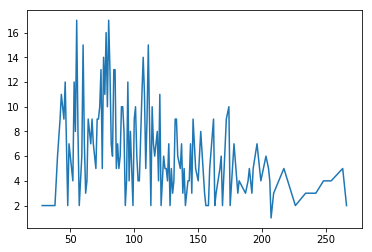

In [48]:
plt.plot(x,y)
plt.show